In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (mean_squared_error, r2_score, accuracy_score,
                             confusion_matrix, classification_report,
                             roc_auc_score, average_precision_score,
                             precision_recall_curve, roc_curve)

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")



In [6]:
# Load Dataset
df = pd.read_csv("data/heart_disease_uci.csv")
df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
df.dropna(inplace=True)
df.head()


,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,1
2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [7]:
# Prepare Features and Targets
X = df.drop(columns=['chol', 'num'])
y_reg = df['chol']
y_clf = df['num']


In [ ]:
print("Non-numeric columns in X:")
print(X.select_dtypes(include=['object']).columns)
# Drop targets and encode categorical variables
X = df.drop(columns=['chol', 'num'])

# Convert categorical string features into numeric
X = pd.get_dummies(X, drop_first=True)

# Check again to confirm all features are numeric
print(X.dtypes)

In [12]:
# Split and Scale Data
X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_clf, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_c_scaled = scaler.fit_transform(X_train_c)
X_test_c_scaled = scaler.transform(X_test_c)


In [13]:
# ElasticNet Regression with Hyperparameter Tuning
alphas = [0.01, 0.1, 1, 10]
l1_ratios = [0.1, 0.5, 0.9]
results = []

for alpha in alphas:
    for l1 in l1_ratios:
        model = ElasticNet(alpha=alpha, l1_ratio=l1, random_state=42)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results.append((alpha, l1, rmse, r2))

results_df = pd.DataFrame(results, columns=['alpha', 'l1_ratio', 'RMSE', 'R2'])

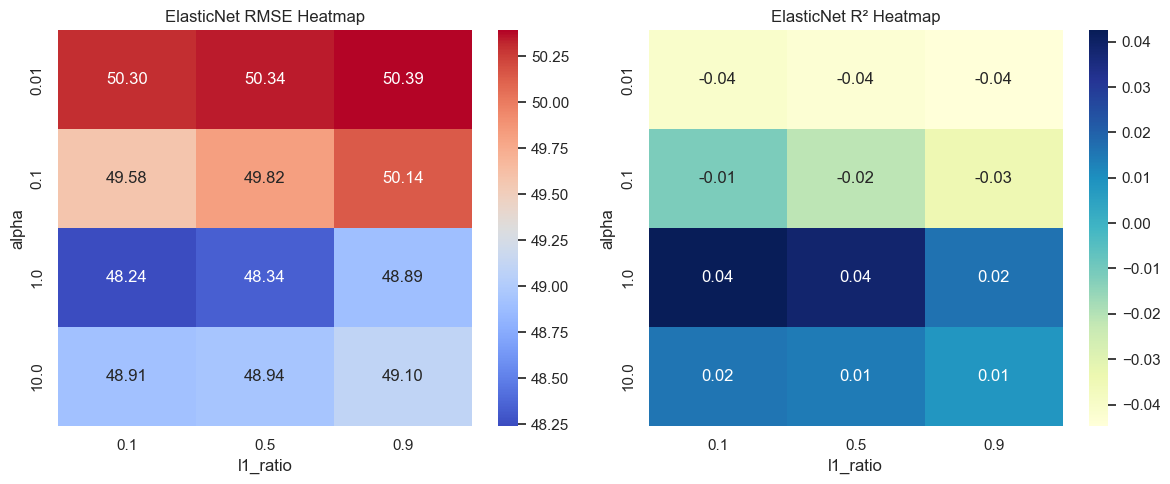

In [15]:
# Heatmaps for ElasticNet RMSE and R²
pivot_rmse = results_df.pivot(index='alpha', columns='l1_ratio', values='RMSE')
pivot_r2 = results_df.pivot(index='alpha', columns='l1_ratio', values='R2')


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(pivot_rmse, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("ElasticNet RMSE Heatmap")
plt.xlabel("l1_ratio")
plt.ylabel("alpha")

plt.subplot(1, 2, 2)
sns.heatmap(pivot_r2, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("ElasticNet R² Heatmap")
plt.xlabel("l1_ratio")
plt.ylabel("alpha")

plt.tight_layout()
plt.show()

In [16]:
# Best ElasticNet Config
best_model = results_df.sort_values('R2', ascending=False).iloc[0]
print("Top Performing ElasticNet Config:")
print(best_model)


Top Performing ElasticNet Config:
alpha        1.000000
l1_ratio     0.100000
RMSE        48.240807
R2           0.042500
Name: 6, dtype: float64


In [17]:
# Logistic Regression and k-NN Classifier Evaluation
best_clf_results = {}
penalties = ['l2']
solvers = ['liblinear', 'lbfgs']

for p in penalties:
    for s in solvers:
        clf = LogisticRegression(penalty=p, solver=s, max_iter=1000)
        clf.fit(X_train_c_scaled, y_train_c)
        y_pred = clf.predict(X_test_c_scaled)
        y_proba = clf.predict_proba(X_test_c_scaled)[:, 1]
        acc = accuracy_score(y_test_c, y_pred)
        f1 = classification_report(y_test_c, y_pred, output_dict=True)['weighted avg']['f1-score']
        auroc = roc_auc_score(y_test_c, y_proba)
        auprc = average_precision_score(y_test_c, y_proba)
        key = f"LogReg_{p}_{s}"
        best_clf_results[key] = (acc, f1, auroc, auprc)

for k in [1, 5, 10]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_c_scaled, y_train_c)
    y_pred = knn.predict(X_test_c_scaled)
    y_proba = knn.predict_proba(X_test_c_scaled)[:, 1]
    acc = accuracy_score(y_test_c, y_pred)
    f1 = classification_report(y_test_c, y_pred, output_dict=True)['weighted avg']['f1-score']
    auroc = roc_auc_score(y_test_c, y_proba)
    auprc = average_precision_score(y_test_c, y_proba)
    key = f"kNN_k={k}"
    best_clf_results[key] = (acc, f1, auroc, auprc)

results_df_clf = pd.DataFrame(best_clf_results).T
results_df_clf.columns = ['Accuracy', 'F1 Score', 'AUROC', 'AUPRC']
results_df_clf


,Accuracy,F1 Score,AUROC,AUPRC
LogReg_l2_liblinear,0.883333,0.882964,0.941714,0.942471
LogReg_l2_lbfgs,0.883333,0.882964,0.941714,0.942471
kNN_k=1,0.850000,0.850887,0.854286,0.741429
kNN_k=5,0.883333,0.883632,0.918857,0.867150
kNN_k=10,0.866667,0.866667,0.947429,0.919423


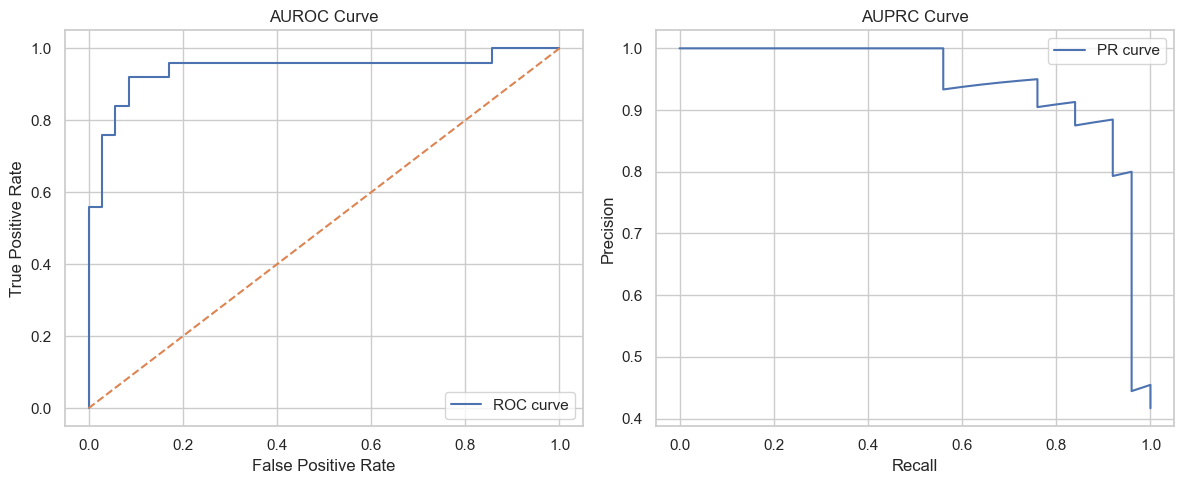

In [18]:
# Plot AUROC and AUPRC for Best Logistic Regression
best_model = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1000)
best_model.fit(X_train_c_scaled, y_train_c)
y_proba = best_model.predict_proba(X_test_c_scaled)[:, 1]

fpr, tpr, _ = roc_curve(y_test_c, y_proba)
precision, recall, _ = precision_recall_curve(y_test_c, y_proba)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label='PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AUPRC Curve')
plt.legend()

plt.tight_layout()
plt.show()
